Analysis of the features (in drawing board notebook) shows that Overall Quality feature is an important feature that we can use to normalize other continuous features. The resultant normalized features often show very good linear relationship with the Sales Price. In this simple model we use only continous features and ignore all of the discrete features except for Overall Quality. In future models we can use some of the discrete features to categorize houses into different groups and assign each group with a more refined pricing model. 

In [110]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as scop

In [111]:
trainset = pd.read_csv('train.csv', index_col = 'Id')
testset = pd.read_csv('test.csv', index_col = 'Id')

The figures below shows that houses with higher overall quality (color closer to yellow) has higher prices for a given lot area. There are other continous features show similar patterns. These patterns suggest that overall quality is an important factor to nomalize some continous features. The resultant normalized features usually have improved linear relationship with the sales price.

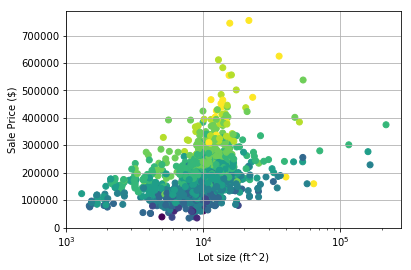

In [112]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.LotArea, trainset.SalePrice, c = trainset.OverallQual)
ax.set_xscale('log')
plt.xlabel('Lot size (ft^2)')
plt.ylabel('Sale Price ($)')
plt.grid()
plt.show()

In [113]:
a = trainset.groupby('OverallQual').SalePrice.agg('mean')
oqmap = a / a.loc[5]

The map above calculates the influence of OverallQual on the sales price. This map is based on known sales price therefore could be overfitting the training set. A less variant model would be using a log linear relationship between overall quality and sales price as the figure below suggests. For now we use the oqmap function above.

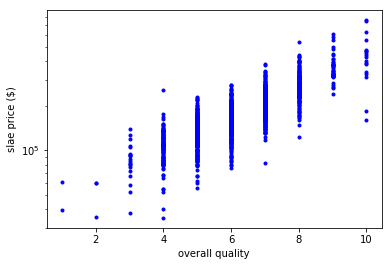

In [114]:
plt.semilogy(trainset.OverallQual, trainset.SalePrice, '.b')
plt.xlabel('overall quality')
plt.ylabel('slae price ($)')
plt.show()

In [115]:
trainset = trainset.assign(LotArea_Q = np.log(trainset.LotArea) * trainset.OverallQual.map(oqmap))
trainset = trainset.assign(LogLotArea = np.log(trainset.LotArea))
trainset[['LotArea', 'LogLotArea', 'LotArea_Q', 'SalePrice']].corr()

,LotArea,LogLotArea,LotArea_Q,SalePrice
LotArea,1.000000,0.697945,0.215848,0.263843
LogLotArea,0.697945,1.000000,0.335918,0.388520
LotArea_Q,0.215848,0.335918,1.000000,0.851368
SalePrice,0.263843,0.388520,0.851368,1.000000


The table above shows that when normalized the linear relationship greatly improves. The reason could be that overall quality represents the factors that are not related to lot area. When those factors are taken out we are essentially comparing houses under the same condition but with different lot area. The normalization distilled the more simple intuitive relationship between lot area and sale price that we see in the figure below.

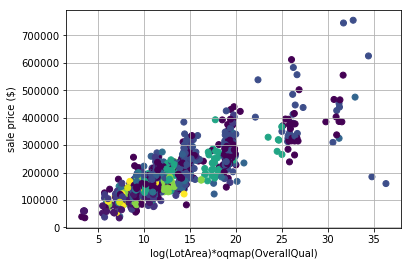

In [116]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.LotArea_Q, trainset.SalePrice, c = trainset.MSSubClass)
plt.xlabel('log(LotArea)*oqmap(OverallQual)')
plt.ylabel('sale price ($)')
plt.grid()
plt.show()

The figure above also shows an example that other discrete features (in this case MSSubClass) can help us further refine the relationships between normalized continous features and the sales price. A refined model would consist of a classification model that puts a house into a specific category and each category has its own regression model (maybe linear). The regression model is each category has reduced error than a general regression model with all houses.

In this model we consider only linear regression over all houses and the refinement discussed above will be investigated in the future.

Below we create a few more normalized continous features that is based on the overall quality. In addition we add the exp(OverallQual) as a continous feature since the logarithmic sale price is well correlated to the overall quality. We also added a feature TotBR represent the total number of bathrooms. It is a feature that is naturally ordered and has a good linear relationship with sales price.

In [117]:
trainset = trainset.assign(FFSF_Q = trainset['1stFlrSF'] * trainset.OverallQual.map(oqmap))
trainset = trainset.assign(GLA_Q = trainset.GrLivArea * trainset.OverallQual.map(oqmap))
trainset = trainset.assign(PosOutSF = trainset.WoodDeckSF + trainset.OpenPorchSF + trainset.ScreenPorch)
trainset = trainset.assign(POSF_Q = trainset.PosOutSF * trainset.OverallQual.map(oqmap))
trainset = trainset.assign(ExpQ = trainset.OverallQual.apply(np.exp))

trainset = trainset.assign(TotBR = trainset.BsmtFullBath + trainset.BsmtHalfBath * 0.5 + trainset.FullBath + trainset.HalfBath * 0.5)

In [118]:
contset = ['LotFrontage', 'LotArea', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'FFSF_Q',
           'LotArea_Q', 'GLA_Q', 'TotBR', 'Fireplaces', 'GarageCars', 'POSF_Q','ExpQ', 'SalePrice']
trainset[contset].corr()

,LotFrontage,LotArea,MasVnrArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,FFSF_Q,LotArea_Q,GLA_Q,TotBR,Fireplaces,GarageCars,POSF_Q,ExpQ,SalePrice
LotFrontage,1.000000,0.426095,0.193458,0.392075,0.457181,0.080177,0.416649,0.359309,0.400998,0.220092,0.266639,0.285691,0.237748,0.288506,0.351799
LotArea,0.426095,1.000000,0.104160,0.260833,0.299475,0.050986,0.226289,0.215848,0.216391,0.204764,0.271364,0.154871,0.197817,0.126207,0.263843
MasVnrArea,0.193458,0.104160,1.000000,0.363936,0.344501,0.174561,0.465630,0.452811,0.485121,0.319557,0.249070,0.364204,0.347806,0.414932,0.477493
TotalBsmtSF,0.392075,0.260833,0.363936,1.000000,0.819530,-0.174512,0.788815,0.599942,0.579591,0.414468,0.339519,0.434585,0.474575,0.494496,0.613581
1stFlrSF,0.457181,0.299475,0.344501,0.819530,1.000000,-0.202646,0.830897,0.565636,0.598228,0.390557,0.410531,0.439317,0.456603,0.469387,0.605852
2ndFlrSF,0.080177,0.050986,0.174561,-0.174512,-0.202646,1.000000,0.031611,0.262289,0.490218,0.375160,0.194561,0.183926,0.215624,0.169724,0.319334
FFSF_Q,0.416649,0.226289,0.465630,0.788815,0.830897,0.031611,1.000000,0.885672,0.867546,0.473020,0.411636,0.537132,0.658076,0.811120,0.793815
LotArea_Q,0.359309,0.215848,0.452811,0.599942,0.565636,0.262289,0.885672,1.000000,0.897974,0.525137,0.407133,0.597824,0.686783,0.826552,0.851368
GLA_Q,0.400998,0.216391,0.485121,0.579591,0.598228,0.490218,0.867546,0.897974,1.000000,0.567686,0.434253,0.539791,0.676252,0.812845,0.837414
TotBR,0.220092,0.204764,0.319557,0.414468,0.390557,0.375160,0.473020,0.525137,0.567686,1.000000,0.331652,0.483578,0.439799,0.359247,0.631731


The feature LotFrontage and MasVnrArea have decent correlation coefficients with sales price. However, both features have a few null values in the training set. In the MasVnrArea the null values are in the houses without masonary vaneer so they can be filled by 0.0. 

We can use other features to estimate the missing values in LotFrontage. The table above shows that LotFrontage and a number of features has decent correlation coefficients (higher than 0.2).

In [119]:
trainset.MasVnrArea.fillna(0.0, inplace = True)

Model 1: estimating Lot Frontage

In [120]:
def lrCost(theta, X, y):
    """linear regression cost function """
    m = X.shape[0]
    return np.dot((np.dot(X, theta) - y).T, np.dot(X, theta) - y) / 2.0 / m

def lrGradient(theta, X, y):
    """ linear regression gradient """
    return np.dot(X.T, np.dot(X, theta) - y) / X.shape[0]

def normdata(a):
    raw_mean = a.mean(axis = 0)
    raw_std = a.std(axis = 0)
    out = np.copy(a)
    for i in range(0, a.shape[1]):
        if raw_std[i] == 0:
            out[:, i] = (a[:, i] + 1.0) / (raw_mean[i] + 1.0)
        else:
            out[:, i] = (a[:, i] - raw_mean[i]) / raw_std[i]
    return out

contset.remove('SalePrice')
ind = trainset.LotFrontage.notnull()
X = np.concatenate((np.ones(shape = (trainset.shape[0], 1)), 
                    trainset[contset[1:]].values.reshape(trainset.shape[0], len(contset) - 1)), axis = 1)
theta0 = np.zeros(shape = (1, len(contset)))
w = scop.fmin_l_bfgs_b(lrCost, theta0, lrGradient, (X[ind, :], trainset.LotFrontage.values[ind]))
w

C:\Users\theya\Anaconda2\lib\site-packages\ipykernel\__main__.py:26: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index


(array([  5.80833318e-07,   7.96850692e-03,  -4.07766423e-04,
          1.57767067e-03,   1.57767067e-03,  -1.77669656e-03,
          1.29442593e-03,   2.70739637e-07,  -1.46950464e-03,
         -6.28357639e-07,   2.66127425e-06,   1.16166664e-06,
          7.62417246e-04,  -1.20784585e-03]),
 1.0223291529623667e-26,
 {'funcalls': 7,
  'grad': array([ -9.30518980e-14,  -8.26618652e-10,  -1.13645179e-11,
          -9.38907083e-11,  -9.38907083e-11,  -4.95168278e-11,
          -1.30776998e-10,  -1.20478439e-12,  -2.07808201e-10,
          -2.90611979e-13,  -3.50696641e-14,  -1.86103796e-13,
          -1.81507924e-11,  -7.77333526e-11]),
  'nit': 3,
  'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'warnflag': 0})

In [121]:
lotfront_para = w[0]
lotfrontage_predict = np.dot(X, lotfront_para.T)
ind = trainset.LotFrontage.isnull()
trainset.LotFrontage[ind] = lotfront_para[ind]

C:\Users\theya\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
C:\Users\theya\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


We filled the missing LotFrontage values from the model above. Next we build a linear regression model between the continous features and the sales price. We remove sales price from the feature list for obvious reasons. We also remove LotArea and instead using LogLotArea since the latter has better linear relationship with sales price.

Model 2: Sales Price model

In [122]:
contset.remove('LotArea')
contset.append('LogLotArea')

In [123]:
X = np.concatenate((np.ones(shape = (trainset.shape[0], 1)), 
                    trainset[contset].values.reshape(trainset.shape[0], len(contset))), axis = 1)
X = normdata(X)
theta0 = np.zeros(shape = (1, len(contset) + 1))
w = scop.fmin_l_bfgs_b(lrCost, theta0, lrGradient, (X, trainset.SalePrice.values))
w

(array([ 180921.11942353,   -1513.55988231,    4112.39373153,
           6684.37600331,   14622.89189604,    3974.80165688,
         -20781.64655968,   41722.87783283,   14359.70324284,
          10607.41234132,    3892.10535214,    9265.54440678,
           3552.05508521,     843.4362208 ,    2343.97498936]),
 567231857.04000294,
 {'funcalls': 49,
  'grad': array([-0.07646688,  0.11284064,  0.02591914,  0.22833551,  0.26114388,
         -0.13857489,  0.17381186,  0.08337406,  0.08692704, -0.06486193,
          0.03742186,  0.25308644,  0.20358246,  0.00045409,  0.05997936]),
  'nit': 37,
  'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
  'warnflag': 0})

Below we estimate the relative error of the model over the training set. The relative error is define as:

$err(y, y_0) = \frac{|y - y_0|}{y_0}$, 

where $y_0$ is the known sales price and $y$ is the predicted sales price.

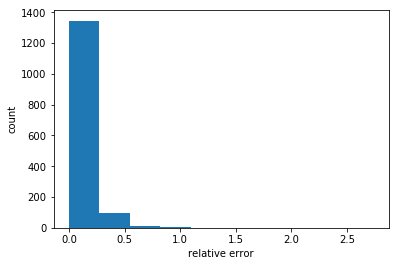

In [124]:
sp_predict = np.dot(X, w[0].T)
err = np.abs(sp_predict - trainset.SalePrice.values) / trainset.SalePrice.values
plt.hist(err)
plt.xlabel('relative error')
plt.ylabel('count')
plt.show()

In [125]:
np.sqrt(np.dot((np.log(sp_predict) - np.log(trainset.SalePrice.values)).T, np.log(sp_predict) - np.log(trainset.SalePrice.values)) / sp_predict.size)

0.16834390029159629

The figure above shows that most of the price predictions has a relative error less than 0.5%. Below we investigate closer to see how the error changes with different houses. 

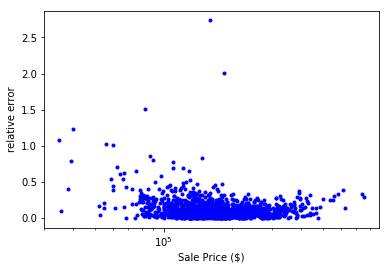

In [126]:
plt.semilogx(trainset.SalePrice, err, '.b')
plt.xlabel('Sale Price ($)')
plt.ylabel('relative error')
plt.show()

The figure above shows that there is a relativley larger amount of error for houses with lower sale prices. This is probably because houses with larger sale price takes more weight in the regression. Those houses contributes more to the overall error therefore in minimizing the overall error we biased toward minimizing the error for the houses with higher prices. To avoid this problem we use the logarithmic of the sale price as the model output.

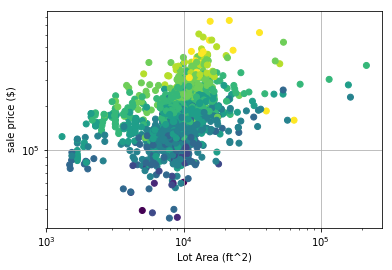

In [127]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.LotArea, trainset.SalePrice, c = trainset.OverallQual)
ax.set_yscale('log')
ax.set_xscale('log')
plt.xlabel('Lot Area (ft^2)')
plt.ylabel('sale price ($)')
plt.grid()
plt.show()

The log(SalePrice) follows aproximately a linear relationship with log(LotArea). Houses with similar log(LotArea) has a positive trend with OverallQual. These observations are close to the case with normal sale prices. Since overall quality forms a linear relationship with the log of sale price we don't need to transform the overall quality before applying it to other features like LotArea for normalization.

In [128]:
trainset = trainset.assign(LogSP = np.log(trainset.SalePrice))
trainset = trainset.assign(LotArea_Q = np.log(trainset.LotArea) * trainset.OverallQual)
trainset = trainset.assign(LogLotArea = np.log(trainset.LotArea))
trainset[['LotArea', 'LogLotArea', 'LotArea_Q', 'SalePrice', 'LogSP']].corr()

,LotArea,LogLotArea,LotArea_Q,SalePrice,LogSP
LotArea,1.000000,0.697945,0.264595,0.263843,0.257320
LogLotArea,0.697945,1.000000,0.397624,0.388520,0.399918
LotArea_Q,0.264595,0.397624,1.000000,0.833069,0.852574
SalePrice,0.263843,0.388520,0.833069,1.000000,0.948374
LogSP,0.257320,0.399918,0.852574,0.948374,1.000000


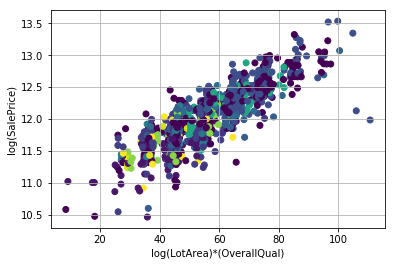

In [129]:
fig = plt.figure
ax = plt.gca()
ax.scatter(trainset.LotArea_Q, trainset.LogSP, c = trainset.MSSubClass)
plt.xlabel('log(LotArea)*(OverallQual)')
plt.ylabel('log(SalePrice)')
plt.grid()
plt.show()

The figure above shows that after considering overall quality the log(SalePrice) and log(LotArea) form a decent linear trend. There are a few other features, like 1stFlrSF, that show similar trends with the log(SalePrice) like the one above.

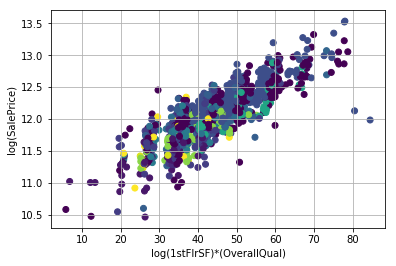

In [130]:
fig = plt.figure
ax = plt.gca()
ax.scatter(np.log(trainset['1stFlrSF']) * trainset.OverallQual, trainset.LogSP, c = trainset.MSSubClass)
plt.xlabel('log(1stFlrSF)*(OverallQual)')
plt.ylabel('log(SalePrice)')
plt.grid()
plt.show()

The figure above also shows an example that other discrete features (in this case MSSubClass) can help us further refine the relationships between normalized continous features and the sales price. A refined model would consist of a classification model that puts a house into a specific category and each category has its own regression model (maybe linear). The regression model is each category has reduced error than a general regression model with all houses.

In this model we consider only linear regression over all houses and the refinement discussed above will be investigated in the future.

Below we create a few more normalized continous features that is based on the overall quality. In addition we add the OverallQual as a continous feature since the logarithmic sale price is well correlated to the overall quality linearly. We also added a feature TotBR represent the total number of bathrooms. It is a feature that is naturally ordered and has a good linear relationship with sales price.

In [131]:
trainset = trainset.assign(FFSF_Q = trainset['1stFlrSF'].replace(0, 0.1).apply(np.log) * trainset.OverallQual)
trainset = trainset.assign(GLA_Q = trainset.GrLivArea.replace(0, 0.1).apply(np.log) * trainset.OverallQual)
trainset = trainset.assign(PosOutSF = trainset.WoodDeckSF + trainset.OpenPorchSF + trainset.ScreenPorch)
trainset = trainset.assign(POSF_Q = trainset.PosOutSF.replace(0, 0.1).apply(np.log) * trainset.OverallQual)

trainset = trainset.assign(TotBR = trainset.BsmtFullBath + trainset.BsmtHalfBath * 0.5 + trainset.FullBath + trainset.HalfBath * 0.5)

In [134]:
contset = ['LotFrontage', 'LogLotArea', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'FFSF_Q', 
           'LotArea_Q', 'GLA_Q', 'TotBR', 'Fireplaces', 'GarageCars', 'POSF_Q','OverallQual', 'SalePrice', 'LogSP']
trainset[contset].corr()

,LotFrontage,LogLotArea,MasVnrArea,TotalBsmtSF,1stFlrSF,2ndFlrSF,FFSF_Q,LotArea_Q,GLA_Q,TotBR,Fireplaces,GarageCars,POSF_Q,OverallQual,SalePrice,LogSP
LotFrontage,1.000000,0.262050,0.105018,0.238289,0.245200,0.042553,0.208506,0.233742,0.197401,0.083135,0.044033,0.165241,0.070287,0.176570,0.209639,0.179319
LogLotArea,0.262050,1.000000,0.122350,0.351838,0.443869,0.080465,0.245376,0.397624,0.229301,0.236315,0.327754,0.272007,0.160633,0.178215,0.388520,0.399918
MasVnrArea,0.105018,0.122350,1.000000,0.360067,0.339850,0.173800,0.431535,0.415759,0.431938,0.314248,0.247015,0.361945,0.259442,0.407252,0.472614,0.426775
TotalBsmtSF,0.238289,0.351838,0.360067,1.000000,0.819530,-0.174512,0.638524,0.588105,0.556666,0.414468,0.339519,0.434585,0.380203,0.537808,0.613581,0.612134
1stFlrSF,0.245200,0.443869,0.339850,0.819530,1.000000,-0.202646,0.615216,0.550783,0.521765,0.390557,0.410531,0.439317,0.336404,0.476224,0.605852,0.596981
2ndFlrSF,0.042553,0.080465,0.173800,-0.174512,-0.202646,1.000000,0.220650,0.298679,0.380661,0.375160,0.194561,0.183926,0.217633,0.295493,0.319334,0.319300
FFSF_Q,0.208506,0.245376,0.431535,0.638524,0.615216,0.220650,1.000000,0.975394,0.984291,0.553976,0.430455,0.622251,0.597804,0.985185,0.829464,0.846622
LotArea_Q,0.233742,0.397624,0.415759,0.588105,0.550783,0.298679,0.975394,1.000000,0.976119,0.559050,0.446079,0.619189,0.589315,0.972271,0.833069,0.852574
GLA_Q,0.197401,0.229301,0.431938,0.556666,0.521765,0.380661,0.984291,0.976119,1.000000,0.583569,0.433379,0.616834,0.602266,0.989665,0.830226,0.849106
TotBR,0.083135,0.236315,0.314248,0.414468,0.390557,0.375160,0.553976,0.559050,0.583569,1.000000,0.331652,0.483578,0.473457,0.541063,0.631731,0.673011


The table above shows the correlation coefficients between Log(SalePrice) (named LogSP) and the continous features choosen for the linear regression model. We also compare that to the original SalePrice. Most of the features have high correlation coefficients to both Sale Price and log(SalePrice). Some features show improved correlation like normalized log(LotArea) (named LotArea_Q) while others has slighly reduced correlation coefficients. All the of the normalized features show improvement in correlation. Here we keep only the features with improved correlation. 

In [136]:
contset = ['LogLotArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'FFSF_Q', 
           'LotArea_Q', 'GLA_Q', 'TotBR', 'Fireplaces', 'GarageCars', 'POSF_Q','OverallQual']

In [137]:
X = np.concatenate((np.ones(shape = (trainset.shape[0], 1)), trainset[contset].values.reshape(trainset.shape[0], len(contset))), axis = 1)
X = normdata(X)
theta0 = np.zeros(shape = (1, len(contset) + 1))
wlog = scop.fmin_l_bfgs_b(lrCost, theta0, lrGradient, (X, trainset.LogSP.values))
wlog

(array([  1.20240461e+01,   1.63348029e-01,   3.84842135e-02,
         -1.25533806e-01,   7.27549207e-03,   7.27710418e-01,
         -5.22045838e-01,   3.18655359e-01,   7.18113053e-02,
          2.66936994e-02,   5.98494488e-02,   1.94326962e-02,
         -2.87502884e-01]),
 0.012533069872026622,
 {'funcalls': 66,
  'grad': array([ -4.84385959e-06,  -4.77518340e-06,   4.63417193e-06,
           6.10071170e-07,   2.26301935e-06,   6.99358098e-06,
           6.60852215e-06,   8.34640531e-06,   1.59985962e-06,
          -8.58113044e-07,   1.88459426e-06,   6.75185897e-06,
           8.91675154e-06]),
  'nit': 61,
  'task': 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL',
  'warnflag': 0})

Below we investigate the error in the training set.

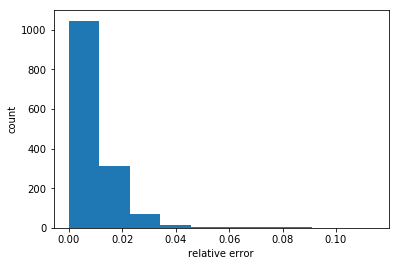

In [138]:
sp_predict = np.dot(X, wlog[0].T)
err = np.abs(sp_predict - trainset.LogSP) / trainset.LogSP
plt.hist(err)
plt.xlabel('relative error')
plt.ylabel('count')
plt.show()

In [139]:
np.sqrt(np.dot((sp_predict - trainset.LogSP.values).T, sp_predict - trainset.LogSP.values) / sp_predict.size)

0.15832289709341868

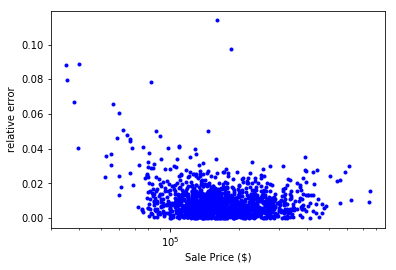

In [140]:
plt.semilogx(trainset.SalePrice, err, '.b')
plt.xlabel('Sale Price ($)')
plt.ylabel('relative error')
plt.show()

Error analysis above show improved relative error and MSRE. The plot of relative error vs. sale price show that the model fits approximately equally to high price and low price houses. Therefore we use the logarithmic model to predict the house price for the test set data.

Use model to predict house price for test set

First we need to examine the test set data for missing values.

In [141]:
nullpercent = testset.isnull().sum() / testset.shape[0]
nullpercent[nullpercent.values > 0]

MSZoning        0.002742
LotFrontage     0.155586
Alley           0.926662
Utilities       0.001371
Exterior1st     0.000685
Exterior2nd     0.000685
MasVnrType      0.010966
MasVnrArea      0.010281
BsmtQual        0.030158
BsmtCond        0.030843
BsmtExposure    0.030158
BsmtFinType1    0.028787
BsmtFinSF1      0.000685
BsmtFinType2    0.028787
BsmtFinSF2      0.000685
BsmtUnfSF       0.000685
TotalBsmtSF     0.000685
BsmtFullBath    0.001371
BsmtHalfBath    0.001371
KitchenQual     0.000685
Functional      0.001371
FireplaceQu     0.500343
GarageType      0.052090
GarageYrBlt     0.053461
GarageFinish    0.053461
GarageCars      0.000685
GarageArea      0.000685
GarageQual      0.053461
GarageCond      0.053461
PoolQC          0.997944
Fence           0.801234
MiscFeature     0.965045
SaleType        0.000685
dtype: float64

In [142]:
testset[testset.MasVnrArea.isnull()].MasVnrType

Id
1692    NaN
1707    NaN
1883    NaN
1993    NaN
2005    NaN
2042    NaN
2312    NaN
2326    NaN
2341    NaN
2350    NaN
2369    NaN
2593    NaN
2658    NaN
2687    NaN
2863    NaN
Name: MasVnrType, dtype: object

In [143]:
testset[testset.BsmtFullBath.isnull()].BsmtQual

Id
2121    NaN
2189    NaN
Name: BsmtQual, dtype: object

In [144]:
testset[testset.GarageCars.isnull()].GarageType

Id
2577    Detchd
Name: GarageType, dtype: object

One house is missing GarageCars feature and this house has a detached style garage. We use the mean value for GarageCars for this garage type in training set to fill this missing value.

In [145]:
trainset.groupby('GarageType').GarageCars.agg(['mean', 'count', 'min', 'max'])

,mean,count,min,max
GarageType,,,,
2Types,3.000000,6,2,4
Attchd,1.964368,870,1,4
Basment,1.578947,19,1,2
BuiltIn,2.250000,88,1,3
CarPort,1.666667,9,1,2
Detchd,1.576227,387,1,4


In [148]:
testset.MasVnrArea.fillna(0.0, inplace = True)
testset.BsmtFullBath.fillna(0, inplace = True)
testset.BsmtHalfBath.fillna(0, inplace = True)
testset.TotalBsmtSF.fillna(0.0, inplace = True)
testset.GarageCars.fillna(1.6, inplace = True)

In [157]:
testset = testset.assign(LotArea_Q = np.log(testset.LotArea.replace(0, 0.1)) * testset.OverallQual)
testset = testset.assign(LogLotArea = np.log(testset.LotArea.replace(0, 0.1)))
testset = testset.assign(FFSF_Q = testset['1stFlrSF'].replace(0, 0.1).apply(np.log) * testset.OverallQual)
testset = testset.assign(GLA_Q = testset.GrLivArea.replace(0, 0.1).apply(np.log) * testset.OverallQual)
testset = testset.assign(PosOutSF = testset.WoodDeckSF + testset.OpenPorchSF + testset.ScreenPorch)
testset = testset.assign(POSF_Q = testset.PosOutSF.replace(0, 0.1).apply(np.log))

testset = testset.assign(TotBR = testset.BsmtFullBath + testset.BsmtHalfBath * 0.5 + testset.FullBath + testset.HalfBath * 0.5)

Since the logarithmic model doesn't use LotFrontage we do not need to fill the missing values.

Below we first combine training and test set inputs into one to normalize the data set. Then we split the training set data out to obtain the regression parameters. Finally we use the regression parameters and normalized test set features to estimate the sale prices for the test set.

In [158]:
contset = ['LogLotArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'FFSF_Q', 
           'LotArea_Q', 'GLA_Q', 'TotBR', 'Fireplaces', 'GarageCars', 'POSF_Q','OverallQual']

In [161]:
Xtrain = np.concatenate((np.ones(shape = (trainset.shape[0], 1)), 
                         trainset[contset].values.reshape(trainset.shape[0], len(contset))), axis = 1)

Xtest = np.concatenate((np.ones(shape = (testset.shape[0], 1)), 
                    testset[contset].values.reshape(testset.shape[0], len(contset))), axis = 1)

In [162]:
Xfull = normdata(np.concatenate((Xtrain, Xtest)))
m = Xtrain.shape[0]

Xtrain = Xfull[:m, :]
Xtest = Xfull[m:, :]

In [163]:
theta0 = np.zeros(shape = (1, len(contset) + 1))
wlog = scop.fmin_l_bfgs_b(lrCost, theta0, lrGradient, (Xtrain, trainset.LogSP.values))
wlog

(array([ 12.01165735,   0.1613457 ,   0.03847028,  -0.12391657,
          0.01537127,   0.76434779,  -0.52775512,   0.26423803,
          0.0740241 ,   0.02681984,   0.06102867,   0.01630323,  -0.26040161]),
 0.01253465608639139,
 {'funcalls': 55,
  'grad': array([  5.99543410e-06,  -7.59700586e-06,  -1.28849640e-05,
          -1.06081979e-06,  -5.11904001e-06,   1.45396725e-05,
          -2.02082132e-06,  -4.38870564e-05,   9.46291281e-06,
          -3.56601332e-06,  -5.57843276e-06,  -1.45755562e-06,
           1.20855716e-05]),
  'nit': 51,
  'task': 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH',
  'warnflag': 0})

In [165]:
test_SalePrice = np.exp(np.dot(Xtest, wlog[0].T))
testset = testset.assign(SalePrice = test_SalePrice)
testset.to_csv('houseprice_log.csv', columns = ['SalePrice'], index = True)

After submitting the results we get a MSRE of 0.17, an improvement over the model predicts just sales price instead of log(sales price).